In [1]:
# Main imports
from econml.dml import DML, LinearDML, SparseLinearDML, CausalForestDML

# Helper imports
import numpy as np
from itertools import product
from sklearn.linear_model import (Lasso, LassoCV, LogisticRegression,
                                  LogisticRegressionCV, LinearRegression,
                                  MultiTaskElasticNet, MultiTaskElasticNetCV)

from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.preprocessing import PolynomialFeatures
import matplotlib.pyplot as plt
import matplotlib
import geopandas as gpd
import pandas as pd

from sklearn.model_selection import train_test_split
%matplotlib inline

In [2]:
import osmnx as ox
import geopandas as gpd
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import rasterio
import warnings
warnings.filterwarnings("ignore")
warnings.simplefilter("ignore")
ox.config(use_cache=True, log_console=False)

In [3]:
src = rasterio.open('LongNTL_2020.tif')

In [4]:
data = pd.read_csv("./LightPollution/London_final.csv")
data = gpd.GeoDataFrame(
    data.loc[:, [c for c in data.columns if c != "geometry"]],
    geometry = gpd.GeoSeries.from_wkt(data["geometry"]),
    crs="EPSG:4326")
data.drop(["Unnamed: 0"], axis = 1, inplace = True)
data

,barrier,highway,name,place,direction,surface,created_by,crossing,source,leisure,...,industrial_mean_distance,industrial_mean_NTL,residential_mean_distance,residential_mean_NTL,retail_mean_distance,retail_mean_NTL,Over_illumination,Trespass,Clutter,geometry
0,NaN,NaN,Former Chalk Lane Hotel,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1799.232483,12.455000,2125.937848,5.545208,1866.281205,12.267499,1634.520264,0.204049,0.000684,POINT (-0.26762 51.32366)
1,NaN,NaN,White City Estate,neighbourhood,NaN,NaN,NaN,NaN,NaN,NaN,...,2320.917661,37.415623,1880.131526,33.520515,1896.175626,34.830849,41442.406250,5.740933,0.002930,POINT (-0.23263 51.51264)
2,NaN,NaN,The Archway Campus,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2306.192673,41.593750,2083.587945,31.458250,1968.583959,34.036335,23358.390625,2.490514,0.001715,POINT (-0.13651 51.56683)
3,NaN,NaN,Regent's Park Estate,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1848.962641,51.812862,1945.047472,54.066280,1804.097565,83.907646,83008.929688,10.238007,0.005087,POINT (-0.14374 51.52699)
4,NaN,NaN,Aldrington Estate,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2039.615158,22.530416,2133.465578,24.879726,1971.178328,25.562187,10792.285156,1.110044,0.001636,POINT (-0.13992 51.42849)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6734,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2082.487335,41.395683,1847.022291,29.004061,1607.225902,26.404228,10795.753906,1.400360,0.001768,"MULTIPOLYGON (((-0.26637 51.51651, -0.26604 51..."
6735,NaN,NaN,Westcott Park,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1807.575356,43.285625,1931.438038,28.357241,1968.027589,25.372561,15127.984375,2.108978,0.002414,"POLYGON ((-0.26126 51.51809, -0.26020 51.51844..."
6736,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1508.675276,3.490000,1415.353641,2.890833,723.431585,3.405000,323.464935,0.034371,0.000192,"POLYGON ((-0.23905 51.29604, -0.23827 51.29483..."
6737,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2195.657159,57.734570,1621.371992,61.991528,1853.299147,62.696556,43182.648438,6.299963,0.004907,"POLYGON ((-0.11846 51.48490, -0.11820 51.48492..."


In [5]:
features = ['brownfield', 'brownfield_mean_distance', 'brownfield_mean_NTL',
            'commercial', 'commercial_mean_distance', 'commercial_mean_NTL',
            'construction', 'construction_mean_distance', 'construction_mean_NTL',
            'farmland', 'farmland_mean_distance', 'farmland_mean_NTL',
            'forest', 'forest_mean_distance', 'forest_mean_NTL', 
            'grass',  'grass_mean_distance', 'grass_mean_NTL',
            'industrial', 'industrial_mean_distance', 'industrial_mean_NTL',
            'residential', 'residential_mean_distance', 'residential_mean_NTL', 
            'retail', 'retail_mean_distance', 'retail_mean_NTL']
len(features)

27

In [6]:
mean_val = data.mean()
data = data.fillna(mean_val)

In [7]:
data["Over_illumination"] = (data["Over_illumination"] - data["Over_illumination"].min()) / (data["Over_illumination"].max() - data["Over_illumination"].min())
data["Trespass"] = (data["Trespass"] - data["Trespass"].min()) / (data["Trespass"].max() - data["Trespass"].min())
data["Clutter"] = (data["Clutter"] - data["Clutter"].min()) / (data["Clutter"].max() - data["Clutter"].min())

In [8]:
data[["Over_illumination", "Trespass", "Clutter"]]

,Over_illumination,Trespass,Clutter
0,0.017105,0.015614,0.057911
1,0.463243,0.464126,0.282384
2,0.260571,0.200828,0.160978
3,0.929091,0.828408,0.498055
4,0.119739,0.089004,0.153025
...,...,...,...
6734,0.119777,0.112521,0.166213
6735,0.168330,0.169922,0.230851
6736,0.002411,0.001870,0.008648
6737,0.482747,0.509409,0.480043


In [9]:
from sklearn.preprocessing import MinMaxScaler

In [15]:
scaler = MinMaxScaler()
W = scaler.fit_transform(data[[c for c in features if c not in ['residential', 'residential_mean_distance', 'residential_mean_NTL']]].values)
T = scaler.fit_transform(data[['residential', 'residential_mean_distance', 'residential_mean_NTL']].values)
Y = data[["Over_illumination", "Trespass", "Clutter"]].values

est = LinearDML(model_y = MultiTaskElasticNetCV(cv = 3, max_iter = 2000),
                model_t = MultiTaskElasticNetCV(cv = 3, max_iter = 2000),
                linear_first_stages = True)

est.fit(Y, T, W = W)

est.effect_inference().summary_frame(alpha = 0.1, value = 0, decimals = 3)

Summary = est.effect_inference().summary_frame(alpha = 0.1, value = 0, decimals = 3)
Summary.reset_index(inplace=True)

Summary["Treatment"] = "residential"

Summary

,X,Y,point_estimate,stderr,zstat,pvalue,ci_lower,ci_upper,Treatment
0,0,Y0,0.243,0.015,16.735,0.0,0.219,0.267,residential
1,0,Y1,0.311,0.018,17.342,0.0,0.282,0.341,residential
2,0,Y2,0.290,0.020,14.462,0.0,0.257,0.323,residential


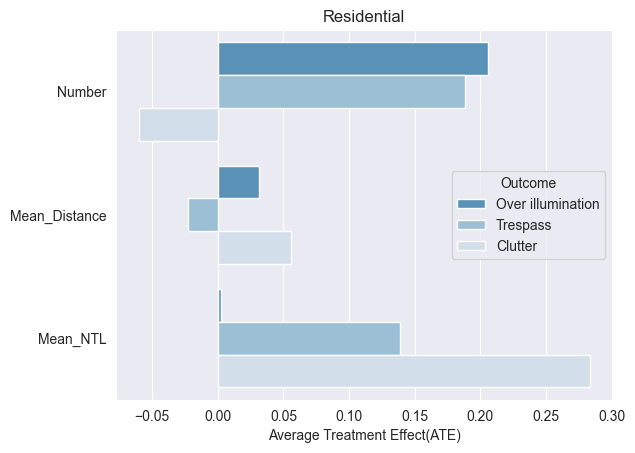

In [11]:
residential_effect = pd.DataFrame(est.const_marginal_ate().T, columns = ["Over illumination", "Trespass", "Clutter"])
residential_effect["Treatment"] = ["Number", "Mean_Distance", "Mean_NTL"]
residential_effect = pd.melt(residential_effect, id_vars=["Treatment"], var_name = "Outcome")
residential_effect

sns.set_style("darkgrid")

flatui = ["#4995C6", "#92C2DD", "#CEDFEF"]
sns.set_palette(flatui)

g = sns.barplot(
    data = residential_effect,
    y="Treatment", x="value", hue="Outcome", palette = sns.color_palette(), alpha = 1,
    orient='h'
)
g.set(ylabel='', xlabel = "Average Treatment Effect(ATE)", title="Residential")
plt.legend(title = "Outcome", loc="center right")
plt.savefig("residential3.svg", bbox_inches = "tight")

In [16]:
scaler = MinMaxScaler()
W = scaler.fit_transform(data[[c for c in features if c not in ['commercial', 'commercial_mean_distance', 'commercial_mean_NTL']]].values)
T = scaler.fit_transform(data[['commercial', 'commercial_mean_distance', 'commercial_mean_NTL']].values)
Y = data[["Over_illumination", "Trespass", "Clutter"]].values

est = LinearDML(model_y = MultiTaskElasticNetCV(cv = 3, max_iter = 2000),
                model_t = MultiTaskElasticNetCV(cv = 3, max_iter = 2000),
                linear_first_stages = True)

est.fit(Y, T, W = W)

est.effect_inference().summary_frame(alpha = 0.1, value = 0, decimals = 3)

summary = est.effect_inference().summary_frame(alpha = 0.1, value = 0, decimals = 3)
summary.reset_index(inplace=True)

summary["Treatment"] = "commercial"
Summary = pd.concat([Summary, summary], axis = 0)

Summary

,X,Y,point_estimate,stderr,zstat,pvalue,ci_lower,ci_upper,Treatment
0,0,Y0,0.243,0.015,16.735,0.000,0.219,0.267,residential
1,0,Y1,0.311,0.018,17.342,0.000,0.282,0.341,residential
2,0,Y2,0.290,0.020,14.462,0.000,0.257,0.323,residential
0,0,Y0,0.279,0.014,20.656,0.000,0.257,0.301,commercial
1,0,Y1,0.208,0.016,13.031,0.000,0.182,0.234,commercial
2,0,Y2,-0.019,0.017,-1.113,0.266,-0.047,0.009,commercial


In [17]:
scaler = MinMaxScaler()
W = scaler.fit_transform(data[[c for c in features if c not in ['retail', 'retail_mean_distance', 'retail_mean_NTL']]].values)
T = scaler.fit_transform(data[['retail', 'retail_mean_distance', 'retail_mean_NTL']].values)
Y = data[["Over_illumination", "Trespass", "Clutter"]].values

est = LinearDML(model_y = MultiTaskElasticNetCV(cv = 3, max_iter = 2000),
                model_t = MultiTaskElasticNetCV(cv = 3, max_iter = 2000),
                linear_first_stages = True)

est.fit(Y, T, W = W)

summary = est.effect_inference().summary_frame(alpha = 0.1, value = 0, decimals = 3)
summary = summary.reset_index()

summary["Treatment"] = "retail"
Summary = pd.concat([Summary, summary], axis = 0)
Summary

,X,Y,point_estimate,stderr,zstat,pvalue,ci_lower,ci_upper,Treatment
0,0,Y0,0.243,0.015,16.735,0.000,0.219,0.267,residential
1,0,Y1,0.311,0.018,17.342,0.000,0.282,0.341,residential
2,0,Y2,0.290,0.020,14.462,0.000,0.257,0.323,residential
0,0,Y0,0.279,0.014,20.656,0.000,0.257,0.301,commercial
1,0,Y1,0.208,0.016,13.031,0.000,0.182,0.234,commercial
2,0,Y2,-0.019,0.017,-1.113,0.266,-0.047,0.009,commercial
0,0,Y0,0.350,0.017,21.082,0.000,0.323,0.378,retail
1,0,Y1,0.294,0.020,14.787,0.000,0.261,0.326,retail
2,0,Y2,0.154,0.025,6.138,0.000,0.113,0.195,retail


In [22]:
scaler = MinMaxScaler()

W = scaler.fit_transform(data[[c for c in features if c not in ['brownfield', 'brownfield_mean_distance', 'brownfield_mean_NTL']]].values)
T = scaler.fit_transform(data[['brownfield', 'brownfield_mean_distance', 'brownfield_mean_NTL']].values)
Y = data[["Over_illumination", "Trespass", "Clutter"]].values

est = LinearDML(model_y = MultiTaskElasticNetCV(cv = 3, max_iter = 2000),
                model_t = MultiTaskElasticNetCV(cv = 3, max_iter = 2000),
                linear_first_stages = True)

est.fit(Y, T, W = W)

est.effect_inference().summary_frame(alpha = 0.1, value = 0, decimals = 3)

Summary2 = est.effect_inference().summary_frame(alpha = 0.1, value = 0, decimals = 3)
Summary2.reset_index(inplace=True)

Summary2["Treatment"] = "brownfield"
# Summary = pd.concat([Summary, summary], axis = 0)

Summary2

,X,Y,point_estimate,stderr,zstat,pvalue,ci_lower,ci_upper,Treatment
0,0,Y0,0.001,0.007,0.147,0.883,-0.010,0.012,brownfield
1,0,Y1,-0.009,0.009,-1.046,0.296,-0.023,0.005,brownfield
2,0,Y2,-0.016,0.009,-1.765,0.078,-0.030,-0.001,brownfield


In [23]:
scaler = MinMaxScaler()
W = scaler.fit_transform(data[[c for c in features if c not in ['construction', 'construction_mean_distance', 'construction_mean_NTL',]]].values)
T = scaler.fit_transform(data[['construction', 'construction_mean_distance', 'construction_mean_NTL',]].values)
Y = data[["Over_illumination", "Trespass", "Clutter"]].values

est = LinearDML(model_y = MultiTaskElasticNetCV(cv = 3, max_iter = 2000),
                model_t = MultiTaskElasticNetCV(cv = 3, max_iter = 2000),
                linear_first_stages = True)

est.fit(Y, T, W = W)
est.effect_inference().population_summary(alpha = 0.1, value = 0, decimals = 3, tol = 0.001)

summary = est.effect_inference().summary_frame(alpha = 0.1, value = 0, decimals = 3)
summary = summary.reset_index()

summary["Treatment"] = "construction"
Summary2 = pd.concat([Summary2, summary], axis = 0)
Summary2

,X,Y,point_estimate,stderr,zstat,pvalue,ci_lower,ci_upper,Treatment
0,0,Y0,0.001,0.007,0.147,0.883,-0.010,0.012,brownfield
1,0,Y1,-0.009,0.009,-1.046,0.296,-0.023,0.005,brownfield
2,0,Y2,-0.016,0.009,-1.765,0.078,-0.030,-0.001,brownfield
0,0,Y0,0.294,0.009,31.501,0.000,0.278,0.309,construction
1,0,Y1,0.266,0.012,22.575,0.000,0.247,0.286,construction
2,0,Y2,-0.041,0.012,-3.276,0.001,-0.061,-0.020,construction


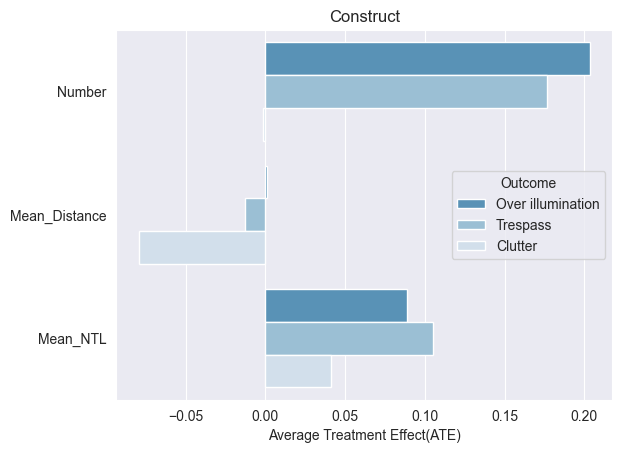

In [23]:
construct_effect = pd.DataFrame(est.const_marginal_ate().T, columns = ["Over illumination", "Trespass", "Clutter"])
construct_effect["Treatment"] = ["Number", "Mean_Distance", "Mean_NTL"]
construct_effect = pd.melt(construct_effect, id_vars=["Treatment"], var_name = "Outcome")
construct_effect

sns.set_style("darkgrid")

flatui = ["#4995C6", "#92C2DD", "#CEDFEF"]
sns.set_palette(flatui)

g = sns.barplot(
    data = construct_effect,
    y="Treatment", x="value", hue="Outcome", palette = sns.color_palette(), alpha = 1,
    orient='h'
)

g.set(ylabel='', xlabel = "Average Treatment Effect(ATE)", title="Construct")
plt.legend(title = "Outcome", loc="center right")
plt.savefig("construct3.svg", bbox_inches = "tight")

In [24]:
scaler = MinMaxScaler()

W = scaler.fit_transform(data[[c for c in features if c not in ['industrial', 'industrial_mean_distance', 'industrial_mean_NTL']]].values)
T = scaler.fit_transform(data[['industrial', 'industrial_mean_distance', 'industrial_mean_NTL',]].values)
Y = data[["Over_illumination", "Trespass", "Clutter"]].values

est = LinearDML(model_y = MultiTaskElasticNetCV(cv = 3),
                model_t = MultiTaskElasticNetCV(cv = 3),
                linear_first_stages = True)

est.fit(Y, T, W = W)

summary = est.effect_inference().summary_frame(alpha = 0.1, value = 0, decimals = 3)
summary = summary.reset_index()

summary["Treatment"] = "industrial"
Summary2 = pd.concat([Summary2, summary], axis = 0)
Summary2

,X,Y,point_estimate,stderr,zstat,pvalue,ci_lower,ci_upper,Treatment
0,0,Y0,0.001,0.007,0.147,0.883,-0.010,0.012,brownfield
1,0,Y1,-0.009,0.009,-1.046,0.296,-0.023,0.005,brownfield
2,0,Y2,-0.016,0.009,-1.765,0.078,-0.030,-0.001,brownfield
0,0,Y0,0.294,0.009,31.501,0.000,0.278,0.309,construction
1,0,Y1,0.266,0.012,22.575,0.000,0.247,0.286,construction
2,0,Y2,-0.041,0.012,-3.276,0.001,-0.061,-0.020,construction
0,0,Y0,0.038,0.009,4.192,0.000,0.023,0.054,industrial
1,0,Y1,0.024,0.013,1.879,0.060,0.003,0.045,industrial
2,0,Y2,0.010,0.014,0.702,0.483,-0.013,0.033,industrial


In [27]:
scaler = MinMaxScaler()
W = scaler.fit_transform(data[[c for c in features if c not in ['grass', 'grass_mean_distance', 'grass_mean_NTL']]].values)
T = scaler.fit_transform(data[['grass', 'grass_mean_distance', 'grass_mean_NTL']].values)
Y = data[["Over_illumination", "Trespass", "Clutter"]].values

est = LinearDML(model_y = MultiTaskElasticNetCV(cv = 3, max_iter = 2000),
                model_t = MultiTaskElasticNetCV(cv = 3, max_iter = 2000),
                linear_first_stages = True)
est.fit(Y, T, W = W)

est.effect_inference().summary_frame(alpha = 0.1, value = 0, decimals = 3)

Summary3 = est.effect_inference().summary_frame(alpha = 0.1, value = 0, decimals = 3)
Summary3.reset_index(inplace=True)

Summary3["Treatment"] = "grass"
Summary3

,X,Y,point_estimate,stderr,zstat,pvalue,ci_lower,ci_upper,Treatment
0,0,Y0,0.140,0.013,10.843,0.0,0.118,0.161,grass
1,0,Y1,0.057,0.015,3.735,0.0,0.032,0.083,grass
2,0,Y2,0.067,0.019,3.541,0.0,0.036,0.098,grass


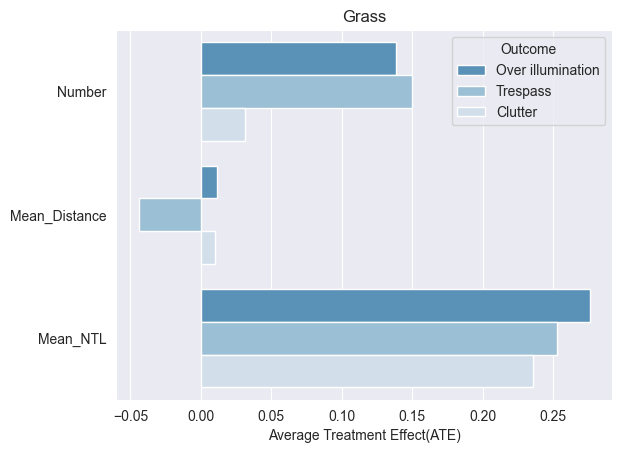

In [26]:
grass_effect = pd.DataFrame(est.const_marginal_ate().T, columns = ["Over illumination", "Trespass", "Clutter"])
grass_effect["Treatment"] = ["Number", "Mean_Distance", "Mean_NTL"]
grass_effect = pd.melt(grass_effect, id_vars=["Treatment"], var_name = "Outcome")
grass_effect

sns.set_style("darkgrid")

flatui = ["#4995C6", "#92C2DD", "#CEDFEF"]
sns.set_palette(flatui)

g = sns.barplot(
    data = grass_effect,
    y = "Treatment", x = "value", hue = "Outcome", palette = sns.color_palette(), alpha = 1,
    orient='h'
)

g.set(ylabel='', xlabel = "Average Treatment Effect(ATE)", title = "Grass")
plt.savefig("grass3.svg", bbox_inches = "tight")

In [28]:
scaler = MinMaxScaler()
W = scaler.fit_transform(data[[c for c in features if c not in ['farmland', 'farmland_mean_distance', 'farmland_mean_NTL']]].values)
T = scaler.fit_transform(data[['farmland', 'farmland_mean_distance', 'farmland_mean_NTL',]].values)
Y = data[["Over_illumination", "Trespass", "Clutter"]].values

est = LinearDML(model_y = MultiTaskElasticNetCV(cv = 3, max_iter = 2000),
                model_t = MultiTaskElasticNetCV(cv = 3, max_iter = 2000),
                linear_first_stages = True)

est.fit(Y, T, W = W)
est.effect_inference().population_summary(alpha = 0.1, value = 0, decimals = 3, tol = 0.001)

summary = est.effect_inference().summary_frame(alpha = 0.1, value = 0, decimals = 3)
summary = summary.reset_index()

summary["Treatment"] = "farmland"
Summary3 = pd.concat([Summary3, summary], axis = 0)
Summary3

,X,Y,point_estimate,stderr,zstat,pvalue,ci_lower,ci_upper,Treatment
0,0,Y0,0.140,0.013,10.843,0.000,0.118,0.161,grass
1,0,Y1,0.057,0.015,3.735,0.000,0.032,0.083,grass
2,0,Y2,0.067,0.019,3.541,0.000,0.036,0.098,grass
0,0,Y0,0.175,0.012,14.213,0.000,0.155,0.196,farmland
1,0,Y1,0.179,0.012,14.430,0.000,0.158,0.199,farmland
2,0,Y2,-0.037,0.012,-3.067,0.002,-0.056,-0.017,farmland


In [29]:
scaler = MinMaxScaler()
W = scaler.fit_transform(data[[c for c in features if c not in ['forest', 'forest_mean_distance', 'forest_mean_NTL']]].values)
T = scaler.fit_transform(data[['forest', 'forest_mean_distance', 'forest_mean_NTL', ]].values)
Y = data[["Over_illumination", "Trespass", "Clutter"]].values

est = LinearDML(model_y = MultiTaskElasticNetCV(cv = 3, max_iter = 2000),
                model_t = MultiTaskElasticNetCV(cv = 3, max_iter = 2000),
                linear_first_stages = True)

est.fit(Y, T, W = W)
est.effect_inference().population_summary(alpha = 0.1, value = 0, decimals = 3, tol = 0.001)

summary = est.effect_inference().summary_frame(alpha = 0.1, value = 0, decimals = 3)
summary = summary.reset_index()

summary["Treatment"] = "forest"
Summary3 = pd.concat([Summary3, summary], axis = 0)
Summary3

,X,Y,point_estimate,stderr,zstat,pvalue,ci_lower,ci_upper,Treatment
0,0,Y0,0.140,0.013,10.843,0.000,0.118,0.161,grass
1,0,Y1,0.057,0.015,3.735,0.000,0.032,0.083,grass
2,0,Y2,0.067,0.019,3.541,0.000,0.036,0.098,grass
0,0,Y0,0.175,0.012,14.213,0.000,0.155,0.196,farmland
1,0,Y1,0.179,0.012,14.430,0.000,0.158,0.199,farmland
2,0,Y2,-0.037,0.012,-3.067,0.002,-0.056,-0.017,farmland
0,0,Y0,0.238,0.009,27.569,0.000,0.224,0.252,forest
1,0,Y1,0.244,0.012,20.772,0.000,0.225,0.264,forest
2,0,Y2,0.044,0.013,3.372,0.001,0.022,0.065,forest


In [30]:
Summary.loc[Summary["Y"]=="Y0", "Y"] = "Over Illumination"
Summary.loc[Summary["Y"]=="Y1", "Y"] = "Trespass"
Summary.loc[Summary["Y"]=="Y2", "Y"] = "Clutter"

Summary.rename(columns={"Y": "Outcome"}, inplace = True)

In [31]:
Summary2.loc[Summary2["Y"]=="Y0", "Y"] = "Over Illumination"
Summary2.loc[Summary2["Y"]=="Y1", "Y"] = "Trespass"
Summary2.loc[Summary2["Y"]=="Y2", "Y"] = "Clutter"

Summary2.rename(columns={"Y": "Outcome"}, inplace = True)

In [32]:
Summary3.loc[Summary3["Y"]=="Y0", "Y"] = "Over Illumination"
Summary3.loc[Summary3["Y"]=="Y1", "Y"] = "Trespass"
Summary3.loc[Summary3["Y"]=="Y2", "Y"] = "Clutter"

Summary3.rename(columns = {"Y": "Outcome"}, inplace = True)

In [33]:
Summarys = [Summary, Summary2, Summary3]

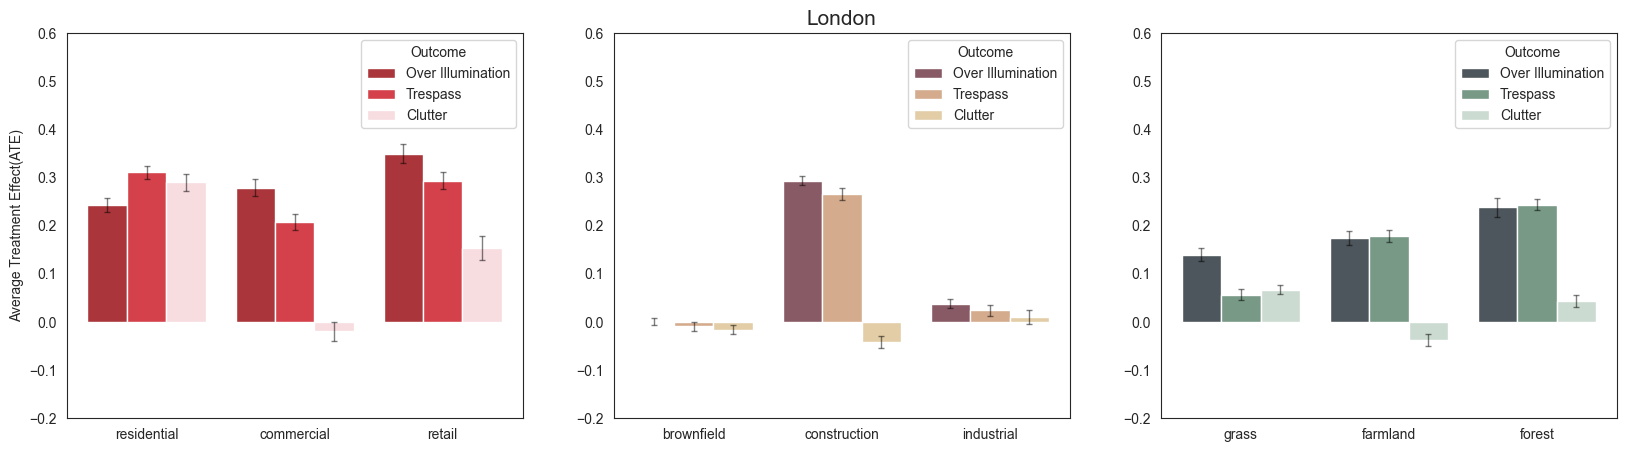

In [35]:
import pandas as pd
import seaborn as sns


# plt.figure(figsize = (20, 5))
sns.set_style("white")

fig, axes = plt.subplots(1, 3, figsize=(20, 5))

flatui = ["#BD2329", "#EC2835", "#FCD7DD"]
sns.set_palette(flatui)

sns.barplot(
    data = Summary,
    x = "Treatment", y = "point_estimate", hue = "Outcome", palette = sns.color_palette(), alpha = 1, ax = axes[0]
)

flatui = ["#8f5362", "#e0a981", "#ecd09c"]
sns.set_palette(flatui)

axes[1] = sns.barplot(
    data = Summary2,
    x = "Treatment", y = "point_estimate", hue = "Outcome", palette = sns.color_palette(), alpha = 1, ax = axes[1]
)

# flatui = ["#79b4a0", "#a3c8a4", "#d4daa1"]
# sns.set_palette(flatui)

flatui = ["#4A565F", "#719F85", "#CADDD1"]
sns.set_palette(flatui)

axes[2] = sns.barplot(
    data = Summary3,
    x = "Treatment", y = "point_estimate", hue = "Outcome", palette = sns.color_palette(), alpha = 1, ax = axes[2]
)

for index in range(3):
    x = Summarys[index]["Treatment"]
    y = Summarys[index]["point_estimate"]
    yerr = Summarys[index]["stderr"]
    
    bars = [c for c in axes[index].get_children() if isinstance(c, matplotlib.patches.Rectangle)]
    bars = bars[:-1]
    
    for i, bar in enumerate(bars):
            height = bar.get_height()
            x_pos = bar.get_x() + bar.get_width() / 2
            axes[index].errorbar(x = x_pos, y = height, yerr = yerr.iloc[i], fmt = 'none', capsize = 2, color = 'black', elinewidth = 1, alpha = 0.5)

# plt.savefig("ATE2.svg", bbox_inches = "tight")
axes[0].set(xlabel = '', ylabel = "Average Treatment Effect(ATE)")

# axes[0].legend().set_visible(False)
# axes[1].legend().set_visible(False)

axes[1].set(xlabel = '', ylabel = "")
axes[0].set_ylim([-0.2, 0.6])
axes[1].set_ylim([-0.2, 0.6])
axes[1].set_title("London", fontsize = 15)
axes[2].set_ylim([-0.2, 0.6])
axes[2].set(xlabel = '', ylabel = "")

plt.savefig("ATE_LD.svg", bbox_inches = "tight")